In [1]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="anon", project="anon", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="anon", project="anon",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [2]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncomment if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path, logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path, **run.config)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [3]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

query = {"$and": [{"tags": "submission"},
                  {"tags": {"$ne": "data-efficiency"}},
                  {"state": "finished"},
                  {"config.n_train": 800},
                  {"config.lr": {"$in": [3e-3, 1e-3]}},
                 ]}


runs, histories = zip(*get_history(query=query))

KeyboardInterrupt: 

In [ ]:
import torch

labels = []
series = []

for run in runs:
    print(run.displayName)
    _, pl_model = load_model_from_run(run)
    pl_model.body.to("cuda")

    test_log_path = load_file_from_run(run, "test_log.pt")
    test_log = torch.load(test_log_path)

    pred_zts = test_log["pred_zts"]
    true_zts = test_log["true_zts"]
    pert_zts = test_log["pert_zts"]

    network_class = run.config["network_class"]
    if network_class == "NN":
        network_class = "NeuralODE"
    
    body_args = tuple(run.config["body_args"])
    if len(body_args) == 0:
        body_args = ""
    elif len(body_args) == 1:
        body_args = f"{body_args[0]}-"
    else:
        body_args = f"{body_args}"
    body_class = run.config["body_class"]
    if body_class == "ChainPendulum":
        body_class = "Pendulum"
    if body_class == "CoupledPendulum":
        body_class == "2-CoupledPendulum"
    body = f"{body_args}{body_class}"
    
    true_energy_pred = pl_model.true_energy(pred_zts.to(torch.float64))
    true_energy_true = pl_model.true_energy(true_zts.to(torch.float64))
    true_energy_pert = pl_model.true_energy(pert_zts.to(torch.float64))
    
    true_energy_rel_diff_pred_true = (true_energy_pred - true_energy_true).abs().div(true_energy_pred.abs() + true_energy_true.abs()).cpu().numpy()

    series += true_energy_rel_diff_pred_true.tolist()
    
    dt = run.config["dt"]
    integration_time = run.config["integration_time"]
    
    
    labels += [(body, network_class, "true_energy_rel_diff_pred_true", batch, dt, integration_time) for batch in range(len(true_energy_rel_diff_pred_true))]

In [ ]:
levels = ['Body', 'Network', "Series", "Batch", "dt", "integration_time"]
index = pd.MultiIndex.from_tuples(labels, names=levels)
df = pd.DataFrame(series, index=index).reset_index()

In [ ]:
df.head()

df = df.rename(columns={i: dt * i for i in range(n_timesteps)})

In [ ]:
df = pd.melt(df, id_vars=levels, var_name="timestep")

In [ ]:
df = df.sort_values(by=levels)

In [ ]:
df["time"] = df["timestep"] * df["dt"]

In [4]:
df = pd.read_csv("energy-conservation.csv")

In [ ]:
#df.to_csv("energy-conservation.csv", index=False)

In [5]:
sns.set(font_scale=1.75)
sns.set_style('whitegrid')
colors = ["#00abdf", "#00058A", "#6A0078", (96/255,74/255,123/255), "#8E6100"]
sns.set_palette(sns.color_palette(colors))

#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 1000

In [6]:
df["Body"].unique()

array(['1-Pendulum', '2-Pendulum', '3-CoupledPendulum', '3-Pendulum',
       '4-CoupledPendulum', '4-Pendulum', '5-Pendulum', 'CoupledPendulum',
       'Gyroscope', 'MagnetPendulum', 'Rotor'], dtype=object)

In [7]:
df = df[(df["Body"] != "4-Pendulum")
        & (df["Body"] != "CoupledPendulum")
       ]

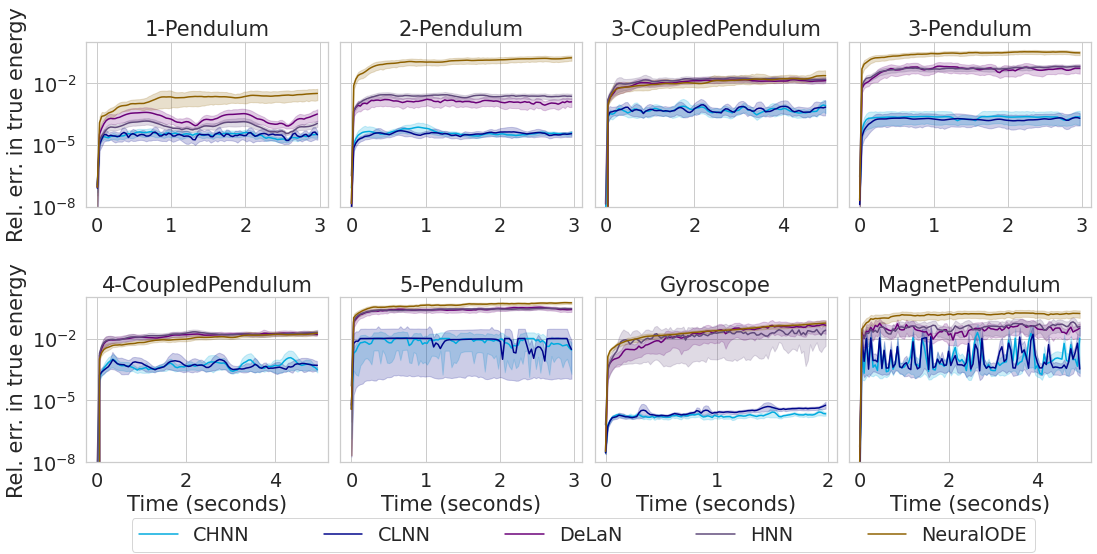

In [8]:
n_plots = len(df["Body"].unique())
ncols = n_plots //2
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(4 * n_plots // 2, 4 * 2))

i = 0
for value, ax in zip(df["Body"].unique(), axes.flatten()):
    data = df.loc[(df["Series"] == "true_energy_rel_diff_pred_true") & (df["Body"] == value)]
    
    #ax.axvline(chunk_len, label=r"$T_{minibatch}$", color="k", linestyle="--", linewidth=1.0)
    sns.lineplot(data=data, x="time", y="value", hue="Network", ax=ax, ci=95)
    
    ax.set(yscale="log", xlabel="", title=f"{value}", ylim=(1e-8, 1), ylabel="")
    
    if i % ncols != 0: # hack
        ax.set(yticklabels=[])
    
    ax.legend().remove()
    i += 1

axes[0][0].set(ylabel="Rel. err. in true energy")
axes[1][0].set(ylabel="Rel. err. in true energy")
#axes[0][0].set(yticklabels=)

for i in range(n_plots // 2):
    axes[-1][i].set(xlabel="Time (seconds)")

handles, labels = axes[0][0].get_legend_handles_labels()
#handles = handles[0:1] + handles[2:]
#labels = labels[0:1] + labels[2:] # Get rid of legend title
labels = labels[1:]
handles = handles[1:]
fig.subplots_adjust(bottom=0.15, wspace=0.05, hspace=0.55)
fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.1, 0., 0.7, 0.), loc="lower center", ncol=len(labels), borderaxespad=0.1, mode="expand")

In [9]:
fig.savefig("energy-conservation.pdf", bbox_inches="tight")